# The Grand Poobah Classification Notebook
In this notebook we will cover uses of scikit-learn for many different purposes including:
- Cross Validation and metrics for scoring (including ROC and confusion matrices)
- Pipelines
- K-Nearest Neighbors 
- Random Forests
- AdaBoost
- Statistical Comparison Questions

We will look at some of the advanced features of scikit and look at many different ways of going about using the system to its fullest potential.

http://en.wikipedia.org/wiki/Grand_Poobah

For this assignment we will use the Olivetti faces dataset and try to perform recognition of different individual's faces with several different classifiers. 

In [1]:
# fetch the images for the dataset
# this will take a long time the first run because it needs to download
# after the first time, the dataset will be save to your disk (in sklearn package somewhere) 
# if this does not run, you may need additional libraries installed on your system (you will need to figure out which ones!!)
from sklearn.datasets import fetch_lfw_people
# pictures from internet, labeled faces
# 13000 images of 1700 people, using a subset
# only load people that have N or more examples in the dataset
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.4) 

Size of the dataset: (3023, 1850)
Number of unique classes: 62
['Colin Powell' 'David Beckham' 'Donald Rumsfeld' 'George Robertson'
 'George W Bush' 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai']


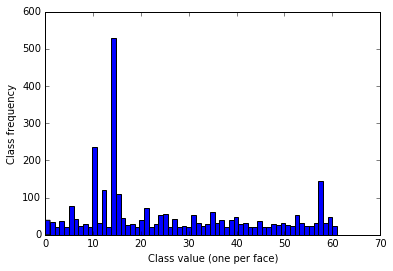

In [5]:
print 'Size of the dataset:', lfw_people.data.shape
print 'Number of unique classes:', len(lfw_people.target_names)
print lfw_people.target_names[10:20]
# feature vector has 1850 columns, one for each pixel position 
# reshape to a matrix and it would be an image
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(lfw_people.target, bins=len(lfw_people.target_names))
plt.xlabel('Class value (one per face)')
plt.ylabel('Class frequency')
plt.show()

In [6]:
lfw_people.data[25]

array([  73.        ,  119.66666412,  143.        , ...,  123.        ,
        187.66667175,  100.33333588], dtype=float32)

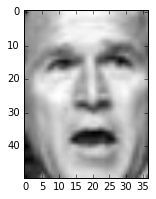

In [7]:
h = 50 # the height in pixels of the original image
w = 37 # the width in pixels of the original image
fig = plt.figure(figsize=(7,3))
plt.imshow(lfw_people.data[25].reshape((h, w)), 
           cmap=plt.cm.gray)
# reshape the row vectors to create the grayscale image

# How should we choose training and testing splits??
- cross validation, how many folds? 10 fold stratified cross validation, stratify because there is much more Bush
- repeated holdout? No
- stratified? Yes

Can use class weights via scikit learn with class_weight variable in sklearn
Try that to weight the classes, improve the results if you want to weight one class heavier, especially if its imbalanced

Can oversample least common class and undersample more common class
Synthetic Minority Overlap Training - repeats rare sample and undersamples common class

# Accuracy, precision, recall?
- How do you perform precision or recall when there are mutliple classes?
Precision and recall used really only for binary classification task, really only makes sense when you have binary
Precision and recall per face George W Bush, have to get those numbers for each person
Accuracy is best here
Can use ROC curve, area under curve, would have to look at set of area under curve
Average precision or median precision or median recall

Recognizing faces is a classification procedure that we want to be accurate. **Detecting faces** might be something where we want low false positives (i.e., when we think there is a face, there should truly be one). Whereas we might be okay with more false negatives (i.e., we miss a few faces in the image). But this is **classification, not face detection**. Therefore, for this dataset it probably makes the most sense to be accurate overall--because we have many classes. 

Even so, an argument can be made for looking at false negatives on a per class basis. For instance, an individual with lots of examples (i.e., a president with many instances in the dataset), we might prefer low false positives for that person. For a person with relatively few examples we might prefer low false negatives (when they do occur, we get them). As such, we might breakup the dataset into two populations
- (1) those that occur frequently (prefer low false positives or high precision)
- (2) those that occur less frequently (prefer low false negatives or high recall)
- (3) the entire dataset (prefer high accuracy)
- (4) NOTE: that recall and precision are not always dealt with like this! You should look at the structure of your application to decide how to apply accuracy, precision, recall or whatever validation measure best defines your data.

Let's start with a simple classifier and ten fold cross validation, calculating accuracy to start.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
import numpy as np
from sklearn import metrics as mt


# create variables we are more familiar with
X = lfw_people.data
y = lfw_people.target
yhat = np.zeros(y.shape) # we will fill this with predictions

# create cross validation iterator
cv = StratifiedKFold(y, n_folds=10)

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf.fit(X[train],y[train]) # fit my model
    yhat[test] = clf.predict(X[test]) # predict based on x test, saving into large vector at test indices, tests on
                                      # every set and saving to my yhat vector, gives me entire y

total_accuracy = mt.accuracy_score(y, yhat)
print 'KNN accuracy', total_accuracy

KNN accuracy 0.324512074099


Well, that was not highly accurate. Let's get the accuracy up before measuring other performance. One thing that might help is reducing the dimensionality of the faces like we have done before. however, instead of manually coding the PCA step and then classifying, let's train a PipeLine in sklearn.

A pipeline allows us to cascade operations. The pipeline can be setup to run PCA, then fit the reduced data with a classifier. The beauty of pipelines comes through when performing different cross validations.

In [9]:
from sklearn.decomposition import RandomizedPCA 
from sklearn.pipeline import Pipeline

# setup pipeline to take PCA, then fit a KNN classifier
clf_pipe = Pipeline( # pipeline, could be a standardizer, or classifier that adds new feature on how classifier treated
                     # feature unions, subclass transformation class
    [('PCA_Eric',RandomizedPCA(n_components=300)), # project down onto PCA eigenvectors
     ('CLF_Eric',KNeighborsClassifier(n_neighbors=1))] # fit the KNN on the PCA eigenvectors now in 300 dimensions
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train]) # fit the k-neighbors classifier
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print 'KNN, pipeline accuracy', total_accuracy

KNN, pipeline accuracy 0.343698312934


Wow, this trained much faster, but did not work much better... Perhaps we should change the classifier we are using--why would this be the case?

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf_pipe = Pipeline(
    [('PCA',RandomizedPCA(n_components=100)),
     ('CLF',RandomForestClassifier(max_depth=50, n_estimators=250, n_jobs=-1))] # now using RFC with all cores
                                                                                # cant use too many estimators (Trees)
                                                                                # cant really overlearn a RFC
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Pipeline accuracy', total_accuracy

Pipeline accuracy 0.317565332451


In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True) # out of bags score = True
# every time we create new tree, we randomly grab instances
# some instances we dont grab because of bootstrap method
# out of bag, not in training set, keep track of how well im performing

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Accuracy', total_accuracy

Accuracy 0.401587826662


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


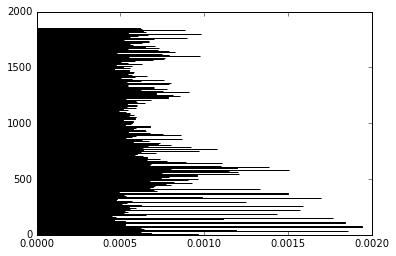

Generalization score estimate from training data 0.371626549964


In [13]:
# now lets get access to the different properties of our RF

print clf

plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_) # feature importances are weird
# takes a column of data, randomly permutes the data, doesnt correspond to right instance and sends it through RCF
# checks to see how well RCF predicts, if i randomly permute the columns, and im still accurate, that means that the
# column was not very important for my classification, if accuracy drops then we know feature was important
# ranks and normalizes
# higher value means feature is more important, randomly permuting dataset around, proves not much bias
# easy way to check to see what features are the most important in your classification model
# if i take this feature importance vector, its telling me the importance of the pixel , we get the below
plt.show()

print 'Generalization score estimate from training data', clf.oob_score_ # check out of bag score, should be close to 
# generalization score, out of bag score almost the same as generalization

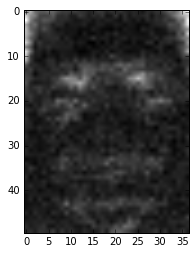

array([ 0.0011284 ,  0.00144745,  0.00096364, ...,  0.00049439,
        0.0006164 ,  0.00044758])

In [15]:
h = 50
w = 37
plt.imshow(clf.feature_importances_.reshape((h, w)), cmap=plt.cm.gray)
plt.show()

# hair, cheekbones, chin are most important
clf.feature_importances_

In [16]:
from sklearn.ensemble import AdaBoostClassifier # boosting, slow
from sklearn.ensemble import RandomForestClassifier # RCF @ tree
from sklearn.ensemble import ExtraTreesClassifier # kaggle competitions uses this, random forest but adds layer of
                                                  # randomness, decides which features for each node, more random than
                                                  # RCF, ETC does @ node level
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)

# lets train some trees
clf_array = [
    dt_stump,
    AdaBoostClassifier(base_estimator=dt_stump,algorithm="SAMME.R",
                       learning_rate=0.5, n_estimators=50),
    ExtraTreesClassifier(n_estimators=50,min_samples_split=1),
    RandomForestClassifier(max_depth=50, n_estimators=50)
    ]

for clf in clf_array:
    acc = cross_val_score(clf,X,y)
    print acc.mean()

0.175364383752
0.192961844835
0.366026923681
0.354339525845


In [22]:
# READ THIS BEFORE RUNNING
# This takes a while to run and gives about the same performance as a decision tree

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dt_stump = DecisionTreeClassifier(max_depth=10, criterion='gini',
            max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=None,
            splitter='best')

clf_pipe = Pipeline(
    [('PCA',RandomizedPCA(n_components=100)),
     ('CLF',AdaBoostClassifier(base_estimator=dt_stump, n_estimators=40))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Pipeline accuracy', total_accuracy

Pipeline accuracy 0.188885213364


In [23]:
from sklearn.neighbors import NearestCentroid


clf_pipe = Pipeline(
    [('PCA',RandomizedPCA(n_components=100)),
     ('CLF',NearestCentroid(metric='cosine'))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Pipeline accuracy', total_accuracy

Pipeline accuracy 0.217664571618


/Library/Python/2.7/site-packages/sklearn/neighbors/nearest_centroid.py:138: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "


In [18]:
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB # GaussianNaiveBayes, no input parameters


# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',RandomizedPCA(n_components=100)),
     ('CLF',GaussianNB())]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print 'Pipeline accuracy', total_accuracy

# Gaussian Naive Bayes is an original machine learning algorithm, outperforming errything
# There is no free lunch - no reason one algorithm should or should not do better than simpler algorithms
# always choose simplest algorithm with decent fit, less likely to overfit with simpler algorithm

Pipeline accuracy 0.538537876282


In [19]:
from sklearn import metrics as mt

freq_infreq_threshold = 40

# get various measures of performance
total_accuracy = mt.accuracy_score(y, yhat)

prec_for_freq_classes = []
recall_for_infreq_classes = []
rec_tot = []
prec_tot = []

for cls in np.unique(y):
    idx = (y==cls) # get classes
    ytmp_actual = np.zeros(y.shape) # make binary class problem
    ytmp_actual[idx] = 1 # set the instances for this specific class
    
    ytmp_predicted = np.zeros(y.shape) # binary prediction array
    ytmp_predicted[yhat==cls] = 1
    
    num_in_class = sum(idx)
    
    rec = mt.recall_score(ytmp_actual, ytmp_predicted)
    prec = mt.precision_score(ytmp_actual, ytmp_predicted)
    rec_tot.append(rec)
    prec_tot.append(prec)
    
    if num_in_class < freq_infreq_threshold:
        recall_for_infreq_classes.append(rec)
    elif num_in_class >= freq_infreq_threshold:
        prec_for_freq_classes.append(prec)
        
print 'Total Accuracy:',total_accuracy
print 'Number of infrequent faces:',len(recall_for_infreq_classes), 'with average recall of:', np.mean(recall_for_infreq_classes)
print 'Number of frequent faces:',len(prec_for_freq_classes), 'with average precision of:',np.mean(prec_for_freq_classes)

Total Accuracy: 0.538537876282
Number of infrequent faces: 43 with average recall of: 0.382774279112
Number of frequent faces: 19 with average precision of: 0.556893853184


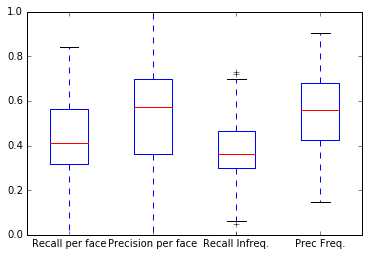

In [20]:
# But we can really summarize this data much better than this. 
# How about looking at more statistics of the precision and recall for each class?

plt.boxplot([rec_tot, prec_tot, recall_for_infreq_classes,prec_for_freq_classes],labels=['Recall per face','Precision per face','Recall Infreq.','Prec Freq.'])
plt.ylim([0,1])
plt.show()

(62, 62)

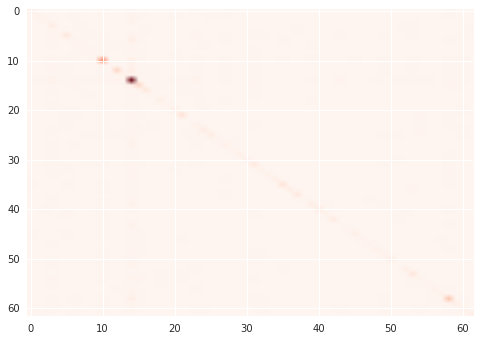

In [39]:

# how about plotting a confusion matrix?
cm = mt.confusion_matrix(y, yhat) # confusion matrix for all classes
plt.imshow(cm, cmap=plt.get_cmap('Reds'),aspect='auto') # plot on imshow method, which is an image method
# graph is not normalized, raw number of times got correct or misclassified
# really want to look at as %

# What is the problem with this graph??

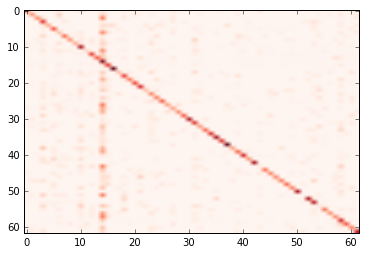

In [26]:
# %load -r 32-33 statcompare.py
# its not normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('Reds'),aspect='auto')

In [27]:
from sklearn.naive_bayes import GaussianNB


# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',RandomizedPCA(n_components=100)),
     ('CLF',GaussianNB())]
)

yhat_score = np.zeros((y.shape[0],len(lfw_people.target_names)))

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])
    yhat_score[test] = clf_pipe.predict_proba(X[test]) # for each of 62 classes, return probability that
                                                       # what ive given you belongs to each class in dataset
                                                       # can grab all probabilities in yhat_score
                                                       # 3000 by 62 matrix, prob for each class
                                                       # ROC uses these thresholds from 0 to 1

total_accuracy = mt.accuracy_score(y, yhat)
print 'Pipeline accuracy', total_accuracy

Pipeline accuracy 0.538207079061


## Using the ROC Curve
In the below example we can see how to graph the false negatives and false positives in an ROC curve for a given classifier. Please note that the "scores" from the classifier have already been populated using the code above. The scores can be interpretted as the the probability that a given class should be designated as positive. These scores are needed so that the ROC can change thresholds deciding if theclass is positive or negative. Once we have the scores, we can send each column of scores (i.e., the probability for that class being positive) into the ROC curve generator and it will give use the arrays of false positives and negatives for that class as the threshold is increased. 

We save the outputs into a dictionary of fpr and tpr (false positive and true positive rates). The keys to the dictionary are the class value. We can also compute the ROC treshold for all the classes by placing their probabilities into one giant vector and whether they should or should not be a value of one. Please note that this method of combining all classes into a single ROC is not considered a standard method--it has limited utility outside classifier comparison. If you understand the limitations it can be an effective tool. If not, then I would not recommend using it to compare models right away. 

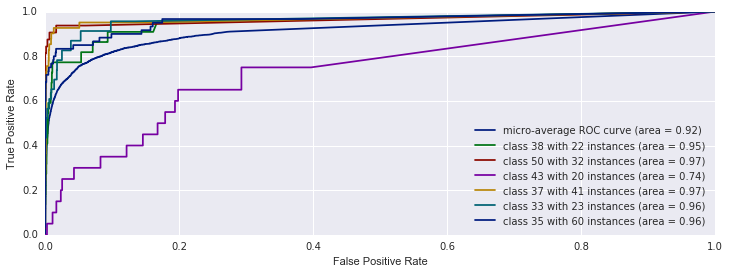

In [30]:
# people dont do this much, 

import seaborn as sns
sns.set_palette("dark")
# code manipulated from http://scikit-learn.org/stable/auto_examples/plot_roc.html
from sklearn.preprocessing import label_binarize

# Compute ROC curve for a subset of interesting classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in np.unique(y):
    fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
    roc_auc[i] = mt.auc(fpr[i], tpr[i])
    
# combined ROC over all classes
one_hot_class_encoding = label_binarize(y,np.unique(y))
fpr["micro"], tpr["micro"], _ = mt.roc_curve(one_hot_class_encoding.ravel(), yhat_score.ravel())
roc_auc["micro"] = mt.auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12,4))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

for i in np.random.permutation(60)[0:6]:
    plt.plot(fpr[i], tpr[i], label='class {0} with {1} instances (area = {2:0.2f})'
                                   ''.format(i, sum(y==i), roc_auc[i]))

plt.legend(loc="lower right")  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Statistical Comparison 
- how might you compare two classifiers trained on the exact same datasets?

Note: if these cells are not loaded, you might need to run the `%load ` magic.

In [32]:
# %load -r 1-15 statcompare.py
clf1 = Pipeline(
    [('PCA',RandomizedPCA(n_components=100)),
     ('CLF',GaussianNB())]
)
clf2 = Pipeline(
    [('PCA',RandomizedPCA(n_components=500)),
     ('CLF',GaussianNB())]
)


from sklearn.cross_validation import cross_val_score
# is clf1 better or worse than clf2?
cv=StratifiedKFold(y,n_folds=10)
acc1 = cross_val_score(clf1, X, y=y, cv=cv)
acc2 = cross_val_score(clf2, X, y=y, cv=cv)

array([ 0.52694611,  0.49074074,  0.48076923,  0.54098361,  0.58      ,
        0.56228956,  0.51535836,  0.59655172,  0.53310105,  0.60142349])

In [34]:
# %load -r 19-28 statcompare.py
t = 2.26 / np.sqrt(10) # 10 for 10 folds, t statistic is 2.26

e = (1-acc1)-(1-acc2) # subtract error rates
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot = np.std(e)

dbar = np.mean(e)
print 'Range of:', dbar-t*stdtot,dbar+t*stdtot  # this is the range of confidence interval
print np.mean(acc1), np.mean(acc2)

Range of: -0.221932946726 -0.176723310355
0.542816386689 0.343488258149


In [37]:
X.shape

(3023, 1850)